# Hands-on: a 2D SPGR (Spoiled Gradient-Recalled Echo) Sequence Example

This tutorial aims to illustrate the sequence design features of Pulserver through building a minimal 2D Spoiled Gradient Recalled Echo (2D SPGR) sequence.
We will demonstrate the built-in high-level design functions as well as show how to customize the sequence using lower-level routines, assuming a basic knowledge of the [(Py)Pulseq](https://github.com/imr-framework/pypulseq/tree/dev) formalism.
Let’s get started!

First, we have to import the relevant packages and define the basic sequence parameters:

In [1]:
import numpy as np
import pypulseq as pp

import pulserver

# Define sequence parameters
fov = 256.0  # Field of view in mm (assume squared FOV)
matrix_size = 256  # Matrix size (assume squared matrix)
n_slices = 1  # Single slice acquisition

flip_angle = 15.0  # Flip angle in degrees
slice_thickness = 5.0  # Slice thickness in mm

Now, we can proceed to the actual sequence design.

## 1. Define system limits
Similarly to a standard (Py)Pulseq sequence, we need to define the system limits object, using the implementation from PyPulseq. This includes the specific scanner gradient and slew rate, the waveforms raster times and the different boards dead and ringdown times.

In this case, we only specify gradient and slew rate, and use the default values for the other attributes:

In [2]:
system_limits = pulserver.Opts(
    max_grad=35, grad_unit="mT/m", max_slew=130, slew_unit="T/m/s"
)
print(system_limits)  # this is an alias for pypulseq.Opts

System limits:
max_grad: 1490160.0000000002
max_slew: 5534880000
rise_time: None
rf_dead_time: 0
rf_ringdown_time: 0
adc_dead_time: 0
adc_raster_time: 1e-07
rf_raster_time: 1e-06
grad_raster_time: 1e-05
block_duration_raster: 1e-05
gamma: 42576000
B0: 1.5


You can notice that gradient and slew rate are automatically converted to ``[Hz]`` and ``[Hz/m/s]``, respectively.

## 2. Instantiate the Sequence object
Now, we instantiate the sequence object. This is designed to provide a similar use experience as native Pulseq's `Sequence` class, but is effectively a `builder <(https://en.wikipedia.org/wiki/Builder_pattern>` we use to create the actual PyPulseq `Sequence` object or the equivalent representations for other Pulseq interpreters (for now, GEHC TOPPE). The aim is providing a familiar syntax to Pulseq users, while minimizing the computationally expensive conversion steps required to adapt the format to different platforms.

In [3]:
seq = pulserver.Sequence(
    system_limits, platform="pulseq"
)  # 'platform' specifies the internal Sequence type

## 3. Define Sequence building blocks

At its core, each MR sequence usually consists of the repetition of a few blocks, each consisting of the simultaneous execution of one or more events (e.g., RF, ADC, Gradient). Throughout the acquisition, some parameters of the blocks, e.g., the amplitude of the phase encoding gradients, are dynamically modified to obtained the desired image properties (e.g., FOV, resolution, contrasts). A basic 2D SPGR sequence, for example, consists of the repetition of the following block structure:

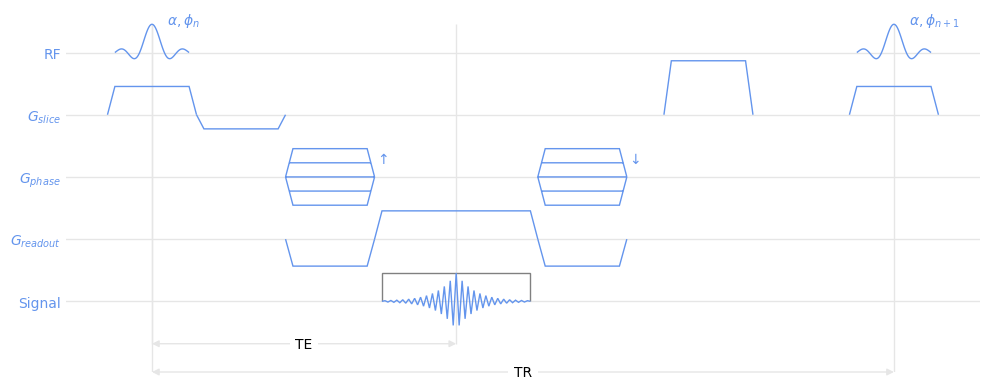

In [4]:
""" Draw the sequence diagram of the FLASH sequence. Adapted from "FLASH
    imaging. Rapid NMR imaging using low flip-angle pulses", Haase et al.,
    Journal of Magnetic Resonance, 67(2), pp. 258-266, 1986.
"""

import copy

import matplotlib.pyplot
import mrsd

# Define sequence parameters (arbitrary units): echo and repetition times,
# durations of ramp, pulses, encoding and readout
TE, TR = 4.1, 10
d_ramp, d_pulse, d_encoding, d_readout = 0.1, 1, 1, 2

# Create the underlying Matplotlib objects and the diagram
figure, plot = matplotlib.pyplot.subplots(figsize=(10, 4), tight_layout=True)

# Set transparent background
figure.patch.set_alpha(0)
plot.patch.set_alpha(0)

# Set the color for ticks, labels, and lines (use black or another neutral color)
plot.spines["bottom"].set_color("cornflowerblue")
plot.spines["top"].set_color("cornflowerblue")
plot.spines["right"].set_color("cornflowerblue")
plot.spines["left"].set_color("cornflowerblue")

plot.xaxis.label.set_color("cornflowerblue")
plot.yaxis.label.set_color("cornflowerblue")
plot.tick_params(axis="x", colors="cornflowerblue")
plot.tick_params(axis="y", colors="cornflowerblue")

diagram = mrsd.Diagram(
    plot, ["RF", "$G_{slice}$", "$G_{phase}$", "$G_{readout}$", "Signal"]
)

# Slice-selective pulse of the first TR
excitation, slice_selection = diagram.selective_pulse(
    "RF",
    "$G_{slice}$",
    d_pulse,
    ramp=d_ramp,
    center=0,
    pulse_kwargs={"ec": "cornflowerblue"},
    gradient_kwargs={"ec": "cornflowerblue"},
)

# Design events
adc = mrsd.ADC(d_readout, center=TE, ec="0.5")
echo = mrsd.Echo(d_readout, 1, center=adc.center, ec="cornflowerblue")
readout = mrsd.Gradient(d_readout, 1, ramp=0.1, center=adc.center, ec="cornflowerblue")
slice_rewind = mrsd.Gradient(
    d_encoding, -0.5, d_ramp, begin=slice_selection.end, ec="cornflowerblue"
)

phase_encoding = mrsd.MultiGradient(
    d_encoding, 1, 0.1, begin=slice_rewind.end, ec="cornflowerblue"
)
readout_prephasing = readout.adapt(
    d_encoding, -0.5, 0.1, begin=slice_rewind.end, ec="cornflowerblue"
)
phase_rewind = mrsd.MultiGradient(
    d_encoding, 1, 0.1, begin=readout.end, edgecolor="cornflowerblue"
)

readout_rewind = readout.adapt(
    d_encoding, -0.5, 0.1, begin=readout.end, ec="cornflowerblue"
)
spoil = readout.adapt(
    d_encoding, 1.0, 0.1, begin=readout_rewind.end + 0.5, ec="cornflowerblue"
)

# Rewind slice selection
diagram.add("$G_{slice}$", slice_rewind)

# Readout
diagram.add("Signal", adc)
diagram.add("Signal", echo)
diagram.add("$G_{readout}$", readout)

# Encoding: rewind slice-selection gradient, run phase gradient, prephase

diagram.add("$G_{phase}$", phase_encoding)
diagram.add("$G_{readout}$", readout_prephasing)

# Post-readout: rewind phase encoding, spoil

diagram.add("$G_{phase}$", phase_rewind)
diagram.add("$G_{readout}$", readout_rewind)
diagram.add("$G_{slice}$", spoil)

# Start of next TR
diagram.add("RF", copy.copy(excitation).move(TR))
diagram.add("$G_{slice}$", copy.copy(slice_selection).move(TR))

# Add annotations: flip angles and TE/TR intervals
diagram.annotate("RF", 0.2, 1, r"$\alpha,\phi_n$", color="cornflowerblue")
diagram.annotate("RF", TR + 0.2, 1, r"$\alpha,\phi_{n+1}$", color="cornflowerblue")
diagram.annotate(
    "$G_{phase}$", phase_encoding.end, 0.5, r"$\uparrow$", color="cornflowerblue"
)
diagram.annotate(
    "$G_{phase}$", phase_rewind.end, 0.5, r"$\downarrow$", color="cornflowerblue"
)
diagram.interval(0, TE, -1.5, "TE", color="black")
diagram.interval(0, TR, -2.5, "TR", color="black")

matplotlib.pyplot.show()

Hence, we need to create the following blocks:

- **RF Excitation**:this consists of the simultaneous execution of an RF event and its accompanying slice selection gradient on z-axis.
- **Slice Rephasing**: this consists of the slice rephasing gradient event on z-axis.
- **Phase encoding**: this consists of simultaneous execution of the phase encoding gradient event on y-axis and the readout pre-winder event on the x-axis.
- **Readout**: this consists of the simultaneous execution of the readout gradient (x-axis) and the ADC event (to record the MR signal).
- **Rewinder**: this is a repetition of the **Phase encoding**, with a scaling factor equal to -1.0 for the y-axis gradient event (reverse polarity).
- **Spoiler**: this consists of the spoiling gradient event on z-axis.

This can be accomplished using `pulserver.blocks` sub-package as follows:

In [5]:
# create excitation and slice rephasing blocks
exc_block, slice_reph_block = pulserver.blocks.make_slr_pulse(
    system_limits, flip_angle, slice_thickness
)

# create phase encoding gradient, readout pre-/re-winder and readout/adc blocks:
phase_enc = pulserver.blocks.make_phase_encoding("y", system_limits, fov, matrix_size)
readout_block, readout_prewind_block = pulserver.blocks.make_line_readout(
    system_limits, fov, matrix_size
)

# create combined phase encoding + readout prewinder block
phase_enc_block = {"gy": phase_enc, **readout_prewind_block}

# create spoiling block
spoil_block = {
    "gz": pulserver.blocks.make_spoiler_gradient(
        "z", system_limits, ncycles=4, voxel_size=fov / matrix_size
    )
}

These blocks have to be registered by using `Sequence.register_block` method. Similarly to `Pypulseq.Sequence.register_*_event`, this is used to efficently re-use sequence blocks throughout the scan loop.

The `Sequence.register_block` method accepts the following arguments:

- **name**: this is the identifier of the block (e.g., ``"excitation"``, ``"readout"``).
- **rf**: this is a RF pulse event. A block can contain either a RF event or an ADC event, not both.
- **gx**: this is a Gradient event along x-axis.
- **gy**: this is a Gradient event along y-axis.
- **gz**: this is a Gradient event along z-axis.
- **adc**: this is an ADC event. A block can contain either a RF event or an ADC event, not both.
- **trig**: this is a trigger event.
- **delay**: this is a delay event, which defines the minimum duration of the block. If the maximum of event durations within a block is lower than this value, a `wait` event will be created by the interpreter so that the duration of the block is equal to `delay`. If the duration is already higher than this value, this is ignored.

To reduce boilerplate, sequence blocks returned by `pulserver.blocks` routines are usually dictionaries with a subset of `(rf, gx, gy, gz, adc, trig, delay)` keys. This way, sequence blocks can be simply registered as:

In [6]:
seq.register_block(name="excitation", **exc_block)
seq.register_block(name="slice_rephasing", **slice_reph_block)
seq.register_block(name="readout", **readout_block)
seq.register_block(name="phase_encoding", **phase_enc_block)
seq.register_block(name="spoiling", **spoil_block)

Block name can be freely chosen by the user, with the exception of `"delay"`: this is reserved as a pure delay block with this name is created during the instantiation of `Sequence` object.

### Custom Blocks

As the input arguments for `Sequence.register_event` are Pypulseq events, the user can leverage the PyPulseq design routines to create custom blocks other then the `Pulserver` built-in. For example, the spoiler gradient could have been designed as:

In [7]:
# Example of a custom block
custom_gz_spoil = pp.make_trapezoid(
    channel="z", area=32 / slice_thickness, system=system_limits
)

and then registered as 

```Python
seq.register_block("custom_spoil", gz=custom_gz_spoil)
```

## 4. Define the Sequence plan

Throughout the scan loop, the basic sequence structure is repeated while changing the phase $\Phi_n$ phase of the RF pulse (RF spoiling), its frequency offset (to excite different slices) and the scaling of the y-gradient events in both **Phase encoding** and **Rewinder** blocks to sample different ky lines in k-space. The gradient amplitude scaling and RF phase and frequency offsets are examples of dynamic sequence parameters, which also include RF amplitude scaling, gradient rotations and variable delay times, that are used to control the image contrast and k-space sampling pattern.

Hence, the user needs to create the schedule for these dynamic sequence parameters. As this require a lot of effort, especially to obtain specific sampling pattern for Parallel Imaging and Compressed Sensing (e.g., CAIPIRINHA and Poisson Disk sampling), we include support routines to 1) generate such sampling masks and RF modulation patterns and 2) retrieve the corresponding gradient / RF amplitude settings at each TR. These support routines are included in `pulserver.plan` subpackage.

We now use this package to create a Cartesian sampling mask and the RF phase list required to obtain RF spoiling:

In [8]:
# total number of RF excitations
n_scans = matrix_size * n_slices

# create RF phase schedule
rf_phases = pulserver.plan.RfPhaseCycle(
    num_pulses=n_scans,
    phase_increment=117.0,  # degrees
)

# create Gy and RF frequency offset schedule to achieve the requested FOV, in-plane resolution and number of slices
encoding_plan, _ = pulserver.plan.cartesian2D(
    g_slice_select=exc_block["gz"],
    slice_thickness=slice_thickness,
    n_slices=n_slices,
    ny=matrix_size,
)  # second output is the (kx, ky) sampling mask, here not necessary because we do not have acceleration

Both `rf_phases` and `encoding_plan` are iterators which keep track of the number of times they have been called, and which can be used to retrieve the actual `rf_phase`, the gradient and rf frequency offsets `(gy_amp, rf_freq)` and the corresponding phase encoding and slice indexes `(iy, iz)` while increasing the readability in case of nested (e.g., phase and slice) loops:

In [9]:
for n in range(4):
    rf_phase = rf_phases()
    encoding, header = encoding_plan()
    print(f"RF phase: {rf_phase} [rad]")
    print(f"Gy amplitude (wrt to peak of gradient waveform): {encoding.gy_amp}")
    print(f"Phase encoding index: {header.iy}")
    print(f"RF frequency offset: {encoding.rf_freq}")
    print(f"Slice index: {header.iz}")

RF phase: 0.0 [rad]
Gy amplitude (wrt to peak of gradient waveform): -0.5
Phase encoding index: 0
RF frequency offset: 0.0
Slice index: 0
RF phase: 0.03564023811504491 [rad]
Gy amplitude (wrt to peak of gradient waveform): -0.49609375
Phase encoding index: 1
RF frequency offset: 0.0
Slice index: 0
RF phase: 0.10692071434513473 [rad]
Gy amplitude (wrt to peak of gradient waveform): -0.4921875
Phase encoding index: 2
RF frequency offset: 0.0
Slice index: 0
RF phase: 0.21384142869026945 [rad]
Gy amplitude (wrt to peak of gradient waveform): -0.48828125
Phase encoding index: 3
RF frequency offset: 0.0
Slice index: 0


Iterators can be rewound by using the `reset()` method:

In [10]:
print(f"RF phase counter before reset: {rf_phases.count}")
print(f"Encoding counter before reset: {encoding_plan.count}")
rf_phases.reset()
encoding_plan.reset()
print(f"RF phase counter after reset: {rf_phases.count}")
print(f"Encoding counter after reset: {encoding_plan.count}")

RF phase counter before reset: 4
Encoding counter before reset: 4
RF phase counter after reset: 0
Encoding counter after reset: 0


### Custom plans
Both the plan design routines and the iterators are just convenience tool to help the user. Since the entities used in dynamic loop definition, as we will see in the next section, are the plain floating point rf/gradient scaling and rotations (float or NumPy NDArrays), the user can leverage `NumPy` and any existing sampling pattern generator package (e.g., [SigPy.RF](https://github.com/mikgroup/sigpy) or [PulPy](https://github.com/jonbmartin/pulpy) to create its own sequence plan:

In [11]:
def my_sequence_plan(ny, nz, Ry):
    """This is actually an example of 3D encoding"""
    # create Gy scaling for ny lines and Ry acceleration factor
    gy_scale = (
        np.arange(ny)[::Ry] - (ny // 2)
    ) / ny  # -0.5:0.5, in-plane acceleration = 2

    # create Gz scaling
    gz_scale = (np.arange(nz) - (nz // 2)) / nz  # -0.5:0.5

    # create Gy, Gz combinations using Gy as faster varying dimension (inner sequence loop)
    return np.meshgrid(
        gy_scale,
        gz_scale,
        indexing="xy",
    )

## 5. Create scan loop

Now that we have all sequence building blocks, it is time to build the actual loop. It is advised to mark the beginning of scan loop with a `pulserver.Sequence.section` method call, which only accepts a `name` argument. The user can concatenate multiple `section` blocks (each corresponding to an individual loop), which can be used to create e.g., the steady state preparation loop, the Parallel Imaging calibration loop or the main sequence loop. The actual section name is not currently used by the builder, but the `section` declaration helps some of the interpreters (e.g., TOPPE) to identify the periodic sequences of the loop. If the interpreter does not use this (e.g., Siemens's Pulseq), `section` marks are ignored, but having them in the code helps the user to better visualize the sequence structure.

In this example, we will design a simple sequence with a single section:

In [12]:
seq.section(name="scan_loop")  # section declaration
for n in range(n_scans):

    # get dynamic sequence parameters
    rf_phase = rf_phases()
    encoding, _ = encoding_plan()

    # update sequence loop
    seq.add_block("excitation", rf_phase=rf_phase, rf_freq=encoding.rf_freq)
    seq.add_block("slice_rephasing")
    seq.add_block("phase_encoding", gy_amp=encoding.gy_amp)
    seq.add_block("readout", adc_phase=rf_phase)
    seq.add_block("phase_encoding", gy_amp=-encoding.gy_amp)
    seq.add_block("spoiling")

Each loop iteration consists essentially in the computation of the current dynamic parameters (here, `(rf_phase, rf_freq, gy_amp)`), followed by an update of the `Sequence` object. This is achieved by using `pulserver.Sequence.add_block` method.

This is conceptually similar to `pypulseq.Sequence.add_block`. However, while the latter directly accepts a list of `pypulseq` events and build a block, `pulserver.Sequence.add_block` expect the identifier (i.e., `name`) of the registered blocks and the following parameters:

- **gx_amp**: amplitude scaling of the x-gradient event in the block (i.e., `gx_amp=1.0` corresponding to the nominal amplitude).
- **gy_amp**: amplitude scaling of the y-gradient event in the block (i.e., `gy_amp=1.0` corresponding to the nominal amplitude).
- **gz_amp**: amplitude scaling of the z-gradient event in the block (i.e., `gz_amp=1.0` corresponding to the nominal amplitude).
- **rf_amp**: amplitude scaling of the RF event in the block (i.e., `rf_amp=1.0` corresponding to the nominal amplitude).
- **rf_phase**: RF pulse phase modulation in `rad` (e.g., for phase cycling and RF spoiling).
- **rf_freq**: RF pulse frequency offset in `Hz` (e.g., for off-isocenter slice excitation, fat saturation or MT preparation).
- **rf_phase**: ADC phase modulation in `rad` (i.e., for signal de-modulation), usually the same as **rf_phase**.
- **delay**: delay time in `s`. For the pure delay block, allows to dynamically modulate sequence timing (e.g., TE, TR) - ignored for standard blocks.
- **rotmat**: Gradient 3D rotation matrix of shape `(3, 3)` - used to rotate the slice orientation or for Non Cartesian imaging.

N.B: after the first `add_block` call, the user cannot register any more sequence blocks.

## 6. Building the sequence 

We are almost there! Now, we can build the sequence by calling the `pulserver.Sequence.build` method.

If `platform=="pulseq"` this will internally take the building blocks, scale and rotate them by using (e.g., using `pypulseq.scale_grad`, `pypulseq.rotate`) and build the actual `pypulseq.Sequence` object by calling `pypulseq.Sequence.add_block`. The result is a native `PyPulseq` sequence object, which can be saved as `pypulseq.Sequence.write_seq`:

In [13]:
# build
seq = seq.build()

# this is now a PyPulseq Sequence object!
print(seq)

Sequence:
shape_library: EventLibrary:
data: 3
type: 0
rf_library: EventLibrary:
data: 256
type: 256
grad_library: EventLibrary:
data: 262
type: 262
adc_library: EventLibrary:
data: 256
type: 0
delay_library: EventLibrary:
data: 0
type: 0
extensions_library: EventLibrary:
data: 0
type: 0
rf_raster_time: 1e-06
grad_raster_time: 1e-05
block_events: 1536


## Wrapping up

These steps can (and should!) be grouped in a design routine:

In [14]:
def design_2D_spgr(
    fov: float,
    matrix_size: int,
    n_slices: int,
    flip_angle: float,
    slice_thickness: float,
    platform: str = "pulseq",
):
    """
    Design a simplified 2D Spoiled Gradient Echo sequence.

    Parameters
    ----------
    fov : float
        In-plane field of view in [m].
    matrix_size : int
        Number of pixels (assume squared matrix).
    n_slices : int
        Number of slices.
    flip_angle : float
        Flip Angle in [deg].
    slice_thickness : float
        Slice thickness in [mm].
    platform : str, optional
        MR scanner platform (e.g., "siemens", "gehc").
        The default is "pulseq" (alias for "siemens").

    Returns
    -------
    pypulse.Sequence | pulserver.Ceq
        Object representing the sequence.
        The format is determined by input platform.

    """
    # define system limits
    system_limits = pulserver.Opts(
        max_grad=35, grad_unit="mT/m", max_slew=130, slew_unit="T/m/s"
    )

    # initialize sequence object
    seq = pulserver.Sequence(
        system_limits, platform="pulseq"
    )  # 'platform' specifies the internal Sequence type

    # Define Blocks
    # -------------
    # create excitation and slice rephasing blocks
    exc_block, slice_reph_block = pulserver.blocks.make_slr_pulse(
        system_limits, flip_angle, slice_thickness
    )

    # create phase encoding gradient, readout pre-/re-winder and readout/adc blocks:
    phase_enc = pulserver.blocks.make_phase_encoding(
        "y", system_limits, fov, matrix_size
    )
    readout_block, readout_prewind_block = pulserver.blocks.make_line_readout(
        system_limits, fov, matrix_size
    )

    # create combined phase encoding + readout prewinder block
    phase_enc_block = {"gy": phase_enc, **readout_prewind_block}

    # create spoiling block
    spoil_block = {
        "gz": pulserver.blocks.make_spoiler_gradient(
            "z", system_limits, ncycles=4, voxel_size=fov / matrix_size
        )
    }

    # register blocks
    seq.register_block(name="excitation", **exc_block)
    seq.register_block(name="slice_rephasing", **slice_reph_block)
    seq.register_block(name="readout", **readout_block)
    seq.register_block(name="phase_encoding", **phase_enc_block)
    seq.register_block(name="spoiling", **spoil_block)

    # Define sequence plan
    # --------------------
    # total number of RF excitations
    n_scans = matrix_size * n_slices

    # create RF phase schedule
    rf_phases = pulserver.plan.RfPhaseCycle(
        num_pulses=n_scans,
        phase_increment=117.0,  # degrees
    )

    # create Gy and RF frequency offset schedule to achieve the requested FOV, in-plane resolution and number of slices
    encoding_plan, _ = pulserver.plan.cartesian2D(
        g_slice_select=exc_block["gz"],
        slice_thickness=slice_thickness,
        n_slices=n_slices,
        ny=matrix_size,
    )  # second output is the (kx, ky) sampling mask, here not necessary because we do not have acceleration

    # Set up scan loop
    # ----------------
    seq.section(name="scan_loop")  # section declaration
    for n in range(n_scans):

        # get dynamic sequence parameters
        rf_phase = rf_phases()
        encoding, _ = encoding_plan()

        # update sequence loop
        seq.add_block("excitation", rf_phase=rf_phase, rf_freq=encoding.rf_freq)
        seq.add_block("slice_rephasing")
        seq.add_block("phase_encoding", gy_amp=encoding.gy_amp)
        seq.add_block("readout", adc_phase=rf_phase)
        seq.add_block("phase_encoding", gy_amp=-encoding.gy_amp)
        seq.add_block("spoiling")

    # build the sequence
    return seq.build()

which can be called as:

In [15]:
seq = design_2D_spgr(
    fov, matrix_size, n_slices, flip_angle, slice_thickness, platform="pulseq"
)
print(seq)

Sequence:
shape_library: EventLibrary:
data: 3
type: 0
rf_library: EventLibrary:
data: 256
type: 256
grad_library: EventLibrary:
data: 262
type: 262
adc_library: EventLibrary:
data: 256
type: 0
delay_library: EventLibrary:
data: 0
type: 0
extensions_library: EventLibrary:
data: 0
type: 0
rf_raster_time: 1e-06
grad_raster_time: 1e-05
block_events: 1536


This can also be used as a custom plugin for the server architecture in the context of online sequence design.